## Final Project Data 720 — Sam Sieloff

### Research Objective
For my **DATA 720 Final Project**, I analyzed **NASCAR pit stop performance** to determine how pit stops  impact overall race results

---


### Background

**NASCAR (National Association for Stock Car Auto Racing)** is a professional motorsport series where 40 drivers race weekly at a variety of track types(short ovals, superspeedways and road courses).

Every driver has a  **pit box**, where their pit crew performs services to the car during the race. These **pit stops** allow teams to:
- Change tires  
- Refuel the car  
- Make handling or aerodynamic adjustments  

Because NASCAR races are often decided by fractions of a second, pit stop efficiency is extremely important. A single slow stop can cost a driver several positions, while a fast and stop can gain track position.

Teams typically make multiple pit stops throughout each race, depending on fuel strategy, tire wear, and caution periods. Because of this, pit crew performance is a major factor in the overall race outcome and championship standings.

This project will focus on analyzing pit stop data from the 2024 NASCAR season to better understand how pit crew performance affects race results. By examining patterns in stop times, positions gained or lost, and crew consistency, I aim to identify trends and relationships that can provide insights into what makes certain pit crews better than others

---


![Pit Crew](Pit%20Crew%20Example.jpg)



### Python imports

We first need to import a few python libraries that we will use throughout this notebook

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


### Functions to pull in data 

Creating functions (also be found in the src folder) to pull data from the **NASCAR Api**

In [2]:

def fetch_pit_data(year, series_num):
    
    series_key = f"series_{series_num}"

    race_list_url = f"https://cf.nascar.com/cacher/{year}/race_list_basic.json"
    response = requests.get(race_list_url)
    data = response.json()

    races_df = pd.DataFrame(data[series_key])

    races_df['race_date'] = pd.to_datetime(races_df['race_date'], errors='coerce')
    races_df = races_df[races_df['race_type_id'] == 1] 

    today = pd.Timestamp.now()
    past_races_df = races_df[races_df['race_date'] <= today]

    race_ids = past_races_df['race_id'].tolist()

    def fetch_single_race(series_num, race_id):
        pit_url = f"https://cf.nascar.com/cacher/live/series_{series_num}/{race_id}/live-pit-data.json"
        response = requests.get(pit_url)
        data = response.json()
        return pd.DataFrame(data)

    pit_data = []
    for race_id in race_ids:
        race_data = fetch_single_race(series_num,race_id)
        race_data['race_id'] = race_id
        pit_data.append(race_data)

    pit_df = pd.concat(pit_data, ignore_index=True)

    return pit_df

In [3]:
def fetch_result_data(year, series_num):

    series_key = f"series_{series_num}"

    race_list_url = f"https://cf.nascar.com/cacher/{year}/race_list_basic.json"
    response = requests.get(race_list_url)
    data = response.json()

    races_df = pd.DataFrame(data[series_key])

    races_df['race_date'] = pd.to_datetime(races_df['race_date'], errors='coerce')
    races_df = races_df[races_df['race_type_id'] == 1] 

    today = pd.Timestamp.now()
    past_races_df = races_df[races_df['race_date'] <= today]

    race_ids = past_races_df['race_id'].tolist()

    def load_race_results(series_num, race_id):
        result_url = f"https://cf.nascar.com/cacher/{year}/{series_num}/{race_id}/weekend-feed.json"
        response = requests.get(result_url)
        data = response.json()
        races = data.get("weekend_race", [])
        df = pd.DataFrame(races[0]["results"])
        df["race_id"] = race_id
        df["race_name"] = races[0].get("race_name")

        return df
        
    result_frames = []
    for id in race_ids:
        df = load_race_results(series_num, id)
        if df is not None:
            result_frames.append(df)
    
    final_df = pd.concat(result_frames, ignore_index=True)

    return final_df

In [4]:
results_2024 = fetch_result_data(2024, 1)
results_2024.to_csv("nascar_2024_cup_results.csv", index=False)

In [5]:
pit_data_2024 = fetch_pit_data(2024,1)
pit_data_2024.to_csv('pit_data_2024.csv', index=False)

In [6]:
results_data = results_2024
pit_data = pit_data_2024

In [7]:
# create a mapping dataframe to convert flag number to readable names

unique_code = pit_data['pit_in_flag_status'].dropna().unique()
code_status = pd.DataFrame({'status_code': unique_code})

status_map = {
    0: None,
    1: 'Green',
    2: 'Yellow',
    3: 'Red',
    4: 'White',
    5: 'Checkered',
    6: None,
    7: None,
    8: 'Hot Track',
    9: 'Cold Track'
}
code_status['status_name'] = code_status['status_code'].map(status_map).fillna('Unknown')

In [8]:
# pulling in race names

race_list_url = "https://cf.nascar.com/cacher/2024/race_list_basic.json"
reponse = requests.get(race_list_url)
race_list = reponse.json()

In [9]:
# Using the race list dataframe to join race name and track name to the pit data based on the race id
# Also, taking the flag status and matching it to the mapping table above to convert flag codes to names

race_list_df = pd.DataFrame(race_list["series_1"])
race_list_df = race_list_df[(race_list_df['race_type_id'] == 1) & (race_list_df['playoff_round'] == 0)]
race_list_df = race_list_df[['race_id','race_name', 'track_name']]

pit_data = pit_data.merge(race_list_df[['race_id','race_name', 'track_name']], on ='race_id', how= 'left')

pit_data['pit_in_flag_status'] = pit_data['pit_in_flag_status'].map(status_map).fillna('Unknown')
pit_data['pit_out_flag_status'] = pit_data['pit_out_flag_status'].map(status_map).fillna('Unknown')


In [10]:
# creating bins for each pit stop time to get a better idea of the variance

bins = [0, 30, 45, 60, 100, 200, 500, 1000, float('inf')]  
labels = ['0-30','30-45','45-60','60-100','100-200','200-500','500-1000','1000+']

pit_data['duration_bucket'] = pd.cut(pit_data['pit_stop_duration'], bins=bins, labels=labels, right=False)

bucket_counts = pit_data['duration_bucket'].value_counts().sort_index()

print(bucket_counts)

duration_bucket
0-30        7251
30-45        261
45-60        208
60-100       268
100-200       66
200-500       72
500-1000      19
1000+          7
Name: count, dtype: int64


As expected, most pit stops are less than 30 seconds. There are a few outliers that  we will have to account for. These are likely stops to fix a damaged car and for our purposes can be removed



In [11]:
# creating a new column for total tires changed based on the seperate tire columns

tire_cols = ['left_front_tire_changed', 'right_front_tire_changed', 'left_rear_tire_changed', 'right_rear_tire_changed']

pit_data[tire_cols] = pit_data[tire_cols].astype(int)

pit_data['tires_changed'] = pit_data[tire_cols].sum(axis=1)

# keeping only relevant columns and removing pit stops greater than two minutes

cols = ['race_id', 'race_name', 'track_name', 'vehicle_number', 'driver_name', 'positions_gained_lost', 'tires_changed', 'pit_stop_duration', 'pit_in_flag_status']
pit_data = pit_data[cols][pit_data['pit_stop_duration'] < 120]


### Creating variables for fast and slow stops

First, I took the median for each pit stop based on the race and the number of tires changed

I then compared each stop to the median and identified a slow stop as a pit stop that was 2.5 seconds slower than the median, while a fast stop is a stop that is 
2.5 seconds quicker than the median

In [12]:
pit_data['slow_stop'] = 0
pit_data['quick_stop'] = 0

groups = pit_data.groupby(['race_id', 'tires_changed'])

for (race, tires), i in groups.groups.items():

    subset = pit_data.loc[i, 'pit_stop_duration']

    median = subset.median()

    slow = median + 2.5
    fast = median - 2.5

    pit_data.loc[i, 'slow_stop'] = (subset > slow).astype(int)
    pit_data.loc[i, 'quick_stop'] = (subset < fast).astype(int)


Printing out a summary of our dataframe

In [13]:
pit_data.head()

,race_id,race_name,track_name,vehicle_number,driver_name,positions_gained_lost,tires_changed,pit_stop_duration,pit_in_flag_status,slow_stop,quick_stop
0,5385,DAYTONA 500,Daytona International Speedway,84,* Jimmie Johnson,1,2,51.0504,Yellow,1,0
1,5385,DAYTONA 500,Daytona International Speedway,41,Ryan Preece,-2,4,31.7310,Yellow,1,0
2,5385,DAYTONA 500,Daytona International Speedway,41,Ryan Preece,0,0,22.9557,Yellow,1,0
6,5385,DAYTONA 500,Daytona International Speedway,48,Alex Bowman,-5,0,2.5692,Yellow,0,0
7,5385,DAYTONA 500,Daytona International Speedway,42,John Hunter Nemechek,-25,4,58.4573,Yellow,1,0


### Aggregate of pit data

Taking an aggregate of the pit data by each driver and race. Some of the fields included are a sum of total green and yellow flag stops, number of two and four tire stops, and the number of fast and slow stops. This will allow us to merge it with race results data

In [14]:

# Group by race and vehicle
agg_pit_data = pit_data.groupby(['race_id', 'race_name', 'track_name','vehicle_number', 'driver_name']).agg(
    positions_gained_lost=('positions_gained_lost', 'sum'),
    total_tires_changed=('tires_changed', 'sum'),
    total_pit_duration=('pit_stop_duration', 'sum'),
    total_stops=('vehicle_number', 'count'),
    avg_pit_duration=('pit_stop_duration', 'mean'),
    st_dev_pit_duration=('pit_stop_duration', 'std'),
    min_pit_duration=('pit_stop_duration', 'min'),
    max_pit_duration=('pit_stop_duration', 'max'),
    slow_stops=('slow_stop', 'sum'),
    quick_stops=('quick_stop', 'sum'),
    green_flag_stops=('pit_in_flag_status', lambda x: (x == 'Green').sum()),
    yellow_flag_stops=('pit_in_flag_status', lambda x: (x != 'Green').sum()),
    two_tire_stops=('tires_changed', lambda x: (x.isin([1, 2])).sum()),
    four_tire_stops=('tires_changed', lambda x: (x > 2).sum())
).reset_index()

agg_pit_data.head()

,race_id,race_name,track_name,vehicle_number,driver_name,positions_gained_lost,total_tires_changed,total_pit_duration,total_stops,avg_pit_duration,st_dev_pit_duration,min_pit_duration,max_pit_duration,slow_stops,quick_stops,green_flag_stops,yellow_flag_stops,two_tire_stops,four_tire_stops
0,5385,DAYTONA 500,Daytona International Speedway,1,Ross Chastain,-15,8,45.6826,6,7.613767,5.727299,2.4690,15.8204,0,0,3,3,0,2
1,5385,DAYTONA 500,Daytona International Speedway,10,Noah Gragson,-18,16,136.6019,9,15.177989,23.013022,2.7694,74.8533,2,2,3,6,0,4
2,5385,DAYTONA 500,Daytona International Speedway,11,Denny Hamlin,-13,8,73.8402,8,9.230025,8.143409,3.2031,26.6272,1,1,3,5,0,2
3,5385,DAYTONA 500,Daytona International Speedway,12,Ryan Blaney,-6,8,45.9468,5,9.189360,6.892869,4.4043,19.6211,1,1,3,2,0,2
4,5385,DAYTONA 500,Daytona International Speedway,14,Chase Briscoe,-16,12,60.9928,7,8.713257,6.119561,2.2355,16.1158,0,0,3,4,0,3


Merging the pit and result data for each race and driver

In [15]:
combined_df = agg_pit_data.merge(
    results_data[
        [
            "race_id","car_number",
            "finishing_position","starting_position",
            "laps_led",
            "finishing_status",
            "qualifying_speed"
        ]
    ],
    left_on=["race_id", "vehicle_number"],
    right_on=["race_id", "car_number"],
    how="left"
)

Looking at our finalized data

In [16]:
combined_df.head()

,race_id,race_name,track_name,vehicle_number,driver_name,positions_gained_lost,total_tires_changed,total_pit_duration,total_stops,avg_pit_duration,...,green_flag_stops,yellow_flag_stops,two_tire_stops,four_tire_stops,car_number,finishing_position,starting_position,laps_led,finishing_status,qualifying_speed
0,5385,DAYTONA 500,Daytona International Speedway,1,Ross Chastain,-15,8,45.6826,6,7.613767,...,3,3,0,2,1,21,21,14,Running,0.0
1,5385,DAYTONA 500,Daytona International Speedway,10,Noah Gragson,-18,16,136.6019,9,15.177989,...,3,6,0,4,10,9,38,5,Running,0.0
2,5385,DAYTONA 500,Daytona International Speedway,11,Denny Hamlin,-13,8,73.8402,8,9.230025,...,3,5,0,2,11,19,8,10,Running,0.0
3,5385,DAYTONA 500,Daytona International Speedway,12,Ryan Blaney,-6,8,45.9468,5,9.189360,...,3,2,0,2,12,30,32,12,Accident,0.0
4,5385,DAYTONA 500,Daytona International Speedway,14,Chase Briscoe,-16,12,60.9928,7,8.713257,...,3,4,0,3,14,10,20,0,Running,0.0


In [17]:
# Removing cars that DNF the race

combined_df = combined_df[combined_df['finishing_status'] == 'Running']

### Creating a correlation matrix of variables

In [18]:

corr_cols = ['finishing_position', 'avg_pit_duration', 'total_pit_duration', 
             'slow_stops', 'quick_stops', 'total_stops', 'laps_led', 'positions_gained_lost', 'starting_position', 'qualifying_speed']
corr_matrix = combined_df[corr_cols].corr()
print("Correlation matrix:\n", corr_matrix['finishing_position'].sort_values(ascending=False))


Correlation matrix:
 finishing_position       1.000000
starting_position        0.397909
slow_stops               0.317612
avg_pit_duration         0.240963
total_pit_duration       0.223205
total_stops              0.121171
positions_gained_lost    0.011262
quick_stops             -0.011846
qualifying_speed        -0.051300
laps_led                -0.267811
Name: finishing_position, dtype: float64


We can see that some of the highest correlated variables to finishing position are starting postition and slow stops. Both of these make sense as a car that has good qualifying speed is likely to finish near the front. It also looks like there might be a relationship between slow pit stops and finishing position.

---

### Plotting a few visuals

First, I plotted the avg pit stop duration per race vs the finishing position. There isn't a super strong correlation that we can see.

Next, we see a box plot of the finishing position vs the number of slow stops. Here we can see a clearer trend between pit stops and finishing position. Looking at the median value, there is an increase based on the number of slow stops until 7 slow stops. We will investigate this further

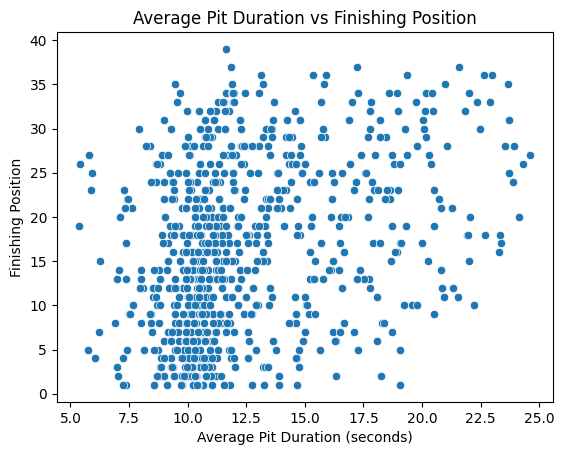

In [19]:
sns.scatterplot(data=combined_df[combined_df['avg_pit_duration'] <= 25], x='avg_pit_duration', y='finishing_position')
plt.title('Average Pit Duration vs Finishing Position')
plt.xlabel('Average Pit Duration (seconds)')
plt.ylabel('Finishing Position')
plt.show()

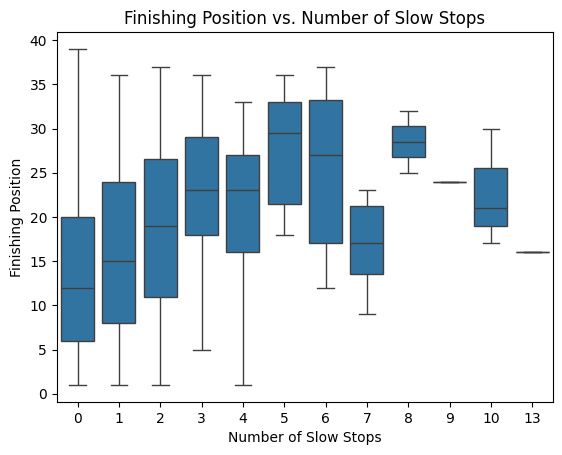

In [20]:
sns.boxplot(x='slow_stops', y='finishing_position', data=combined_df)
plt.title('Finishing Position vs. Number of Slow Stops')
plt.xlabel('Number of Slow Stops') 
plt.ylabel('Finishing Position')
plt.show()

### Creating a linear regression model

Based on the visuals we created and the correlation matrix, we can create a regression model. The two variables I selected are the variables with the highest correlation to finishing position: slow stops and starting postition

In [21]:
# Creating training and test data for the predictor and response variables

X = combined_df[['slow_stops', 'starting_position']]
y = combined_df['finishing_position'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
#creating and training the model based on the training data

model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [23]:
predictions = model.predict(X_test)

In [24]:
r_squared = model.score(X_test, y_test)
print(f"R-squared: {r_squared}")

R-squared: 0.2137774731011326


Our R-squared value of .21 isn't super high, but not bad for attempting to model something with as much randomness as a NASCAR race

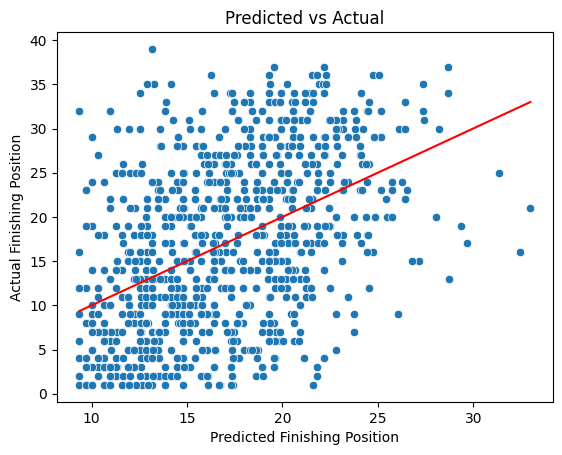

In [25]:
combined_df['predicted'] = model.predict(X)

sns.scatterplot(x='predicted', y='finishing_position', data=combined_df)
plt.plot([combined_df['predicted'].min(), combined_df['predicted'].max()],
         [combined_df['predicted'].min(), combined_df['predicted'].max()],
         color='red')  
plt.xlabel("Predicted Finishing Position")
plt.ylabel("Actual Finishing Position")
plt.title("Predicted vs Actual")
plt.show()


In [26]:
print("Intercept:", model.intercept_)
for name, coef in zip(X.columns, model.coef_):
    print(f"{name}: {coef}")

Intercept: 9.04147027381746
slow_stops: 1.3125369877228599
starting_position: 0.318467430297026


Printing our model coefficients we can observe the modeled relationship between slow stops and finishing position

---

### Adding driver results to the model
In an attempt to improve the model, I would like to add driver information to the model. To do this, I took the average finishing position for each driver over the course of the season. With more time, I would use a rolling 5 or 10 race split instead of the full season. 

In [27]:
driver_avg = combined_df.groupby(['vehicle_number']).agg(
    avg_finishing_position = ('finishing_position', 'median')

).reset_index()

driver_avg.head()

,vehicle_number,avg_finishing_position
0,1,12.0
1,10,14.0
2,11,8.5
3,12,10.0
4,13,6.0


In [28]:
# Adding average finishing position to the model 

combined_df = combined_df.merge(
    driver_avg,
    on='vehicle_number',
    how='left'
)
combined_df.head()

,race_id,race_name,track_name,vehicle_number,driver_name,positions_gained_lost,total_tires_changed,total_pit_duration,total_stops,avg_pit_duration,...,two_tire_stops,four_tire_stops,car_number,finishing_position,starting_position,laps_led,finishing_status,qualifying_speed,predicted,avg_finishing_position
0,5385,DAYTONA 500,Daytona International Speedway,1,Ross Chastain,-15,8,45.6826,6,7.613767,...,0,2,1,21,21,14,Running,0.0,15.729286,12.0
1,5385,DAYTONA 500,Daytona International Speedway,10,Noah Gragson,-18,16,136.6019,9,15.177989,...,0,4,10,9,38,5,Running,0.0,23.768307,14.0
2,5385,DAYTONA 500,Daytona International Speedway,11,Denny Hamlin,-13,8,73.8402,8,9.230025,...,0,2,11,19,8,10,Running,0.0,12.901747,8.5
3,5385,DAYTONA 500,Daytona International Speedway,14,Chase Briscoe,-16,12,60.9928,7,8.713257,...,0,3,14,10,20,0,Running,0.0,15.410819,15.0
4,5385,DAYTONA 500,Daytona International Speedway,15,Riley Herbst(i),-29,14,129.7705,9,14.418944,...,1,3,15,24,36,0,Running,0.0,24.443909,26.5


### Correlation

Taking the correlation between the finish position for the race and a drivers avg finishing position. We can see that there is a strong correlation that might help our model

In [29]:

corr_cols = ['finishing_position', 'avg_finishing_position']
corr_matrix = combined_df[corr_cols].corr()
print("Correlation matrix:\n", corr_matrix['finishing_position'].sort_values(ascending=False))


Correlation matrix:
 finishing_position        1.000000
avg_finishing_position    0.512138
Name: finishing_position, dtype: float64


### Running the model again

Creating another linear regression model with the driver avg finish added. We have a higher R-Squared than our first attempt. 

In [30]:
X = combined_df[['slow_stops', 'starting_position', 'avg_finishing_position']]
y = combined_df['finishing_position'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

r_squared = model.score(X_test, y_test)
print(f"R-squared: {r_squared}")
print("Intercept:", model.intercept_)
for name, coef in zip(X.columns, model.coef_):
    print(f"{name}: {coef}")

R-squared: 0.33536797694033726
Intercept: 3.8362075021454594
slow_stops: 1.0790266537927324
starting_position: 0.11560445152815862
avg_finishing_position: 0.5811919285735565


### Conclusion

Modeling a NASCAR race result is extremely difficult because so much of the race is random. You can have a driver lead for 499/500 laps and then blow out a tire on the last lap and finish last. A model isn't built to "expect" stuff like that. Even with all the randomness, a few things showed up as meaningfully connected to how well a driver finishes. 

First, slow pit stops do matter. In the linear model, each slow stop was associated with roughly one lost finishing position, and if you look at the median differences in stop times, the impact can be even bigger. Small mistakes on pit road add up quickly.

Second, starting position has an effect, but not as strong as you might think. What stood out more was how strong the driver has been over the course of the season. A driver's average finishing position ended up being one of the best predictors of where they finish a given race, even after controlling for pit performance and where they started.

So even though predicting race results perfectly is impossible, the analysis above does show that pit performance and overall driver strength have measurable influence on finishing position.